TODO:
- use DEM and RSGISLIB to calculate slope as another input for stratification
- get 'soil type' map - some kind of geological map?

In [127]:
%pip install ipywidgets -q
%pip install --upgrade ipywidgets -q
%pip install spyndex -q
%pip install dask -q
%pip install dask-expr -q
%pip install odc-stac -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [128]:
import os
import json
from io import StringIO
import numpy as np
import xarray as xr
import geopandas as gpd
import shapely.geometry
import rasterio
import rioxarray

from geodata_fetch.harvest import DataHarvester
from gis_utils.dataframe import get_bbox_from_geodf

import spyndex

from rasterio.plot import show
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, interact

import dask.distributed
from dask.diagnostics import ProgressBar
from rasterio.enums import Resampling

from IPython.display import display
from pystac_client import Client
from odc.stac import configure_rio, stac_load

In [129]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

/usr/local/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34223 instead
  warnings.warn(
2024-06-25 02:10:14,499 - distributed.scheduler - INFO - State start


2024-06-25 02:10:14,521 - distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:39409
2024-06-25 02:10:14,522 - distributed.scheduler - INFO -   dashboard at:  http://127.0.0.1:34223/status
2024-06-25 02:10:14,523 - distributed.scheduler - INFO - Registering Worker plugin shuffle
2024-06-25 02:10:14,578 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:44987'
2024-06-25 02:10:14,583 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45159'
2024-06-25 02:10:14,663 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:44305'
2024-06-25 02:10:14,676 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:43527'
2024-06-25 02:10:14,688 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45483'
2024-06-25 02:10:15,271 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:35153', name: 0, status: init, memory: 0, processing: 0>
2024-06-25 02:10:15,273 - distributed.sch

In [130]:
def is_valid_pixel(data):
    # include only vegetated, not_vegitated, water, and snow
    return ((data > 3) & (data < 7)) | (data==11)

In [131]:
def plot_geotiff(filename):
    file_path = os.path.join(output_dir, filename)
    with rasterio.open(file_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax, title=filename)
        plt.show()

#### Setup import and export directories, bring in geometry for aoi

In [132]:
#links to input and output directories
input_dir = "/workspace/notebooks/sandbox/data/stratification"
test_areas_dir = os.path.join(input_dir, "test-areas")

output_dir = "/workspace/notebooks/sandbox/data/stratification/input-rasters"

GET_DEM = True
GET_SLGA = True
GET_SENTINEL = True

In [133]:
# setup stac for getting veg indices later

stac_url_sentinel = "https://earth-search.aws.element84.com/v1/"
collection_sentinel = "sentinel-2-l2a"

start_date = "2024-04-01"
end_date = "2024-06-01"

resolution = 20

In [134]:
geojson = {
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
}

/tmp/ipykernel_4344/3462533652.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lon = gdf.centroid.x[0] #approximate centre latitude based on the input geojson - point roughly in the middle
/tmp/ipykernel_4344/3462533652.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lat = gdf.centroid.y[0]


bbox: [116.26012130269045, -29.307384715430175, 116.3875862387774, -29.220237788279107]


<Axes: >

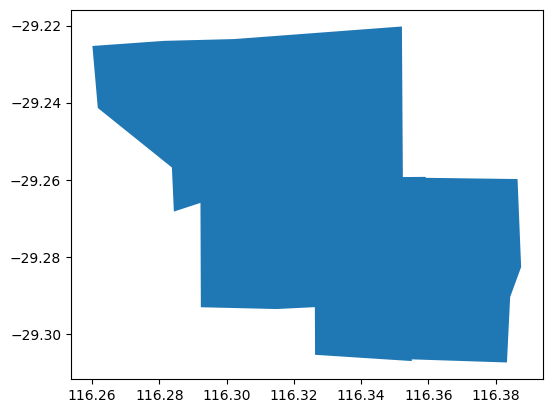

In [135]:
# import geometry for area of interest

req = geojson
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

geom = gdf.geometry #for data-harvester clip function

bbox = get_bbox_from_geodf(geojson_data)
gdf_lon = gdf.centroid.x[0] #approximate centre latitude based on the input geojson - point roughly in the middle
gdf_lat = gdf.centroid.y[0]

print(f"bbox: {bbox}")

gdf.plot()

#### Set up the json object to be sent to the data harvester

A couple of variations on input data to collect:

In [136]:
dem_source = {
    "DEM": "DEM",
    "SLGA": {
        "Organic_Carbon": ["0-5cm"]
    }
}


slga_sources = {
    "SLGA": {
        "Organic_Carbon": ["0-5cm"],
        "Bulk_Density": ["0-5cm"]
    }
}


In [137]:
propertyName = "stardew_valley"


data_mask=False #we want the full geotiffs so making the datacube is easier
add_buffer = False
resample=False #we will handle resampling in the pre-processing notebook to maintain consistency.

# Resolution of data download in arcseconds (1 arcsec ~ 30m)
target_res = 1
target_proj = "EPSG:4326" # We will reproject to 3857 later on. This will be more accurate for data collection and pre-processing steps.

date_start = "2022-10-01" #these aren't needed for SLGA but are expected in the package and throw error if excluded - need to fix
date_end = "2022-11-30"
time_intervals = 0 #same issue as above, need to fix in geodata package to be optional.

In [138]:
if GET_DEM is True:
    json_data = {
        "property_name":propertyName,
        "outpath": output_dir,
        "data_mask": data_mask,
        "target_res": str(target_res),
        "target_crs": target_proj,
        "date_start": date_start if date_start is not None else "2022-10-01", #a date of some kind must be provided or the harvester complains
        "date_end": date_end if date_end is not None else "2022-11-30",
        "target_centroid_lat": gdf_lat,
        "target_centroid_lng": gdf_lon,
        "time_intervals": time_intervals,
        "target_sources": dem_source,
        "target_bbox": bbox,
        "add_buffer": add_buffer,
        "resample": resample
    }

    #do this to check for any inputs that can't be serialised to json
    for key, value in json_data.items():
        if isinstance(value, np.ndarray):
            print(f"Key '{key}' contains an ndarray.")
    data = json.dumps(json_data)

    # Create a file-like object from JSON string
    json_file_like = StringIO(data)
    
    harvester = DataHarvester(json_file_like, geom)
    harvester.run()


Requested the following 2 sources: ['DEM', 'SLGA']
WCS data downloaded and saved as SLGA_Organic_Carbon_0-5cm_stardew_valley.tiff
SLGA data downloaded successfully: ['SLGA_Organic_Carbon_0-5cm_stardew_valley']
/workspace/notebooks/sandbox/data/stratification/input-rasters/DEM_SRTM_1_Second_Hydro_Enforced_stardew_valley.tiff


In [139]:
if GET_SLGA is True:
    json_data = {
        "property_name":propertyName,
        "outpath": output_dir,
        "data_mask": data_mask,
        "target_res": str(target_res),
        "target_crs": target_proj,
        "date_start": date_start if date_start is not None else "2022-10-01", #a date of some kind must be provided or the harvester complains
        "date_end": date_end if date_end is not None else "2022-11-30",
        "target_centroid_lat": gdf_lat,
        "target_centroid_lng": gdf_lon,
        "time_intervals": time_intervals,
        "target_sources": slga_sources,
        "target_bbox": bbox,
        "add_buffer": add_buffer,
        "resample": resample
    }

    #do this to check for any inputs that can't be serialised to json
    for key, value in json_data.items():
        if isinstance(value, np.ndarray):
            print(f"Key '{key}' contains an ndarray.")
    data = json.dumps(json_data)

    # Create a file-like object from JSON string
    json_file_like = StringIO(data)
    
    harvester = DataHarvester(json_file_like, geom)
    harvester.run()

Requested the following 1 sources: ['SLGA']
WCS data downloaded and saved as SLGA_Organic_Carbon_0-5cm_stardew_valley.tiff
WCS data downloaded and saved as SLGA_Bulk_Density_0-5cm_stardew_valley.tiff
SLGA data downloaded successfully: ['SLGA_Organic_Carbon_0-5cm_stardew_valley', 'SLGA_Bulk_Density_0-5cm_stardew_valley']


#### Get Sentinel-2 and indices

TODO: add soil and moisture indices alongside NDVI

In [140]:
if GET_SENTINEL is True:
    catalog = Client.open(stac_url_sentinel)

    query = catalog.search(
        collections=["sentinel-2-l2a"],
        datetime=f"{start_date}/{end_date}",
        bbox=bbox
    )

    items = list(query.items())

    #lazily combine
    xx = stac_load(
        items,
        bands = ("red", "green", "blue", "nir", "scl"),
        crs=target_proj,
        resolution = resolution,
        chunks={}, # use dask
        groupby = "solar_day", #this merges adjacent scenes and de-duplicates overlapping pixels
        bbox = bbox,
        resampling="bilinear"
    )

    xx = xx.load()
    xx['valid'] = is_valid_pixel(xx.scl)
    xx = xx/10000

    xx['ndvi'] = (xx.nir - xx.red) / (xx.nir + xx.red)
    ndvi_median = (
        xx['ndvi']
        .where(xx.valid)
        .median(dim="time")
    )

    ndvi_filename = f"NDVI_median_{start_date}_{end_date}_{propertyName}.tiff"
    ndvi_filepath = os.path.join(output_dir, ndvi_filename)
    ndvi_tiff = ndvi_median.odc.write_cog(ndvi_filepath, overwrite=True)

/usr/local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
